In [1]:
#Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tcn import TCN

In [2]:
#Feature engineering

demand_weather_merged = pd.read_parquet('data/demand_weather_merged_0.8.parquet')

label_encoder = LabelEncoder()

features = demand_weather_merged[['temperature_2m', 'precipitation', 'month', 
                                   'snow_depth', 'pressure_msl', 'cloud_cover', 
                                   'sunshine_duration', 
                                   'day_of_week', 'building_id_encoded']]

features_df = pd.DataFrame(features)
constant_features = features_df.columns[features_df.nunique() <= 1]
features_df = features_df.drop(columns=constant_features)

# Input sequence for forecasting in the model window_size = weeks
window_size = 4

# Changing continuous variable in dataset to discrete for classification
bin_edges = [0, 28, 56, 84, np.inf]
num_classes = len(bin_edges) - 1

demand_weather_merged['y_bin'] = np.digitize(demand_weather_merged['y'], bins=bin_edges, right=False) - 1
target = demand_weather_merged['y_bin']

def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X, dtype='float32'), np.array(y, dtype='float32')

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

X, y = create_sequences(features_scaled, target, window_size)
building_ids = features_df['building_id_encoded'].values[window_size:]

# 80% training and 20% temp
X_train, X_temp, y_train, y_temp, train_building_ids, temp_building_ids = train_test_split(
    X, y, building_ids, test_size=0.2, random_state=42
)

# Split the 20% temp set into 50% validation and 50% test
X_val, X_test, y_val, y_test, val_building_ids, test_building_ids = train_test_split(
    X_temp, y_temp, temp_building_ids, test_size=0.5, random_state=42
)

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_val_categorical = to_categorical(y_val, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [3]:
#Model and training

def build_tcn(input_shape, num_buildings, learning_rate=0.001):
    time_series_input = Input(shape=input_shape, name="time_series_input")
    building_input = Input(shape=(1,), name="building_id")

    tcn_output = TCN(kernel_size=3,
                     nb_filters=128,
                     dilations=[1, 2, 4, 8],
                     activation='relu',
                     dropout_rate=0.1,
                     return_sequences=False)(time_series_input)

    embedding_size = 64
    building_embedding = Embedding(input_dim=num_buildings + 1, output_dim=embedding_size)(building_input)
    building_embedding = Flatten()(building_embedding)

    combined = Concatenate()([tcn_output, building_embedding])

    dense = Dense(32, activation='relu')(combined)
    dropout = Dropout(0.3)(dense)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=[time_series_input, building_input], outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (window_size, X_train.shape[2])
learning_rate = 0.001
num_buildings = demand_weather_merged['building_id_encoded'].nunique()
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

tcn_model = build_tcn(input_shape, num_buildings, learning_rate)
history = tcn_model.fit(
    [X_train, train_building_ids],
    y_train_categorical,
    validation_data=([X_val, val_building_ids], y_val_categorical),
    epochs=100, 
    batch_size=128,
    callbacks=[early_stopping]
)

val_loss, val_accuracy = tcn_model.evaluate([X_val, val_building_ids], y_val_categorical)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

y_pred = tcn_model.predict([X_test, test_building_ids])

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

Epoch 1/100
3160/3160 [==============================] - 29s 8ms/step - loss: 0.7189 - accuracy: 0.6981 - val_loss: 0.5514 - val_accuracy: 0.7736
Epoch 2/100
3160/3160 [==============================] - 27s 8ms/step - loss: 0.5604 - accuracy: 0.7729 - val_loss: 0.5255 - val_accuracy: 0.7850
Epoch 3/100
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5363 - accuracy: 0.7801 - val_loss: 0.5133 - val_accuracy: 0.7873
Epoch 4/100
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5234 - accuracy: 0.7840 - val_loss: 0.5063 - val_accuracy: 0.7903
Epoch 5/100
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5150 - accuracy: 0.7865 - val_loss: 0.5032 - val_accuracy: 0.7923
Epoch 6/100
3160/3160 [==============================] - 25s 8ms/step - loss: 0.5093 - accuracy: 0.7883 - val_loss: 0.4997 - val_accuracy: 0.7914
Epoch 7/100
3160/3160 [==============================] - 25s 8ms/step - loss: 0.5039 - accuracy: 0.7900 - val_loss: 0.4992 -

In [4]:
# Saving models

tcn_model.save('saved_model/tcn_model_0.8_4.h5')


Classification Metrics:
Accuracy: 0.8058
Precision: 0.8083
Recall: 0.8058
F1 Score: 0.8066

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     13088
           1       0.80      0.82      0.81     18936
           2       0.69      0.72      0.70      9937
           3       0.83      0.86      0.84      8597

    accuracy                           0.81     50558
   macro avg       0.80      0.80      0.80     50558
weighted avg       0.81      0.81      0.81     50558



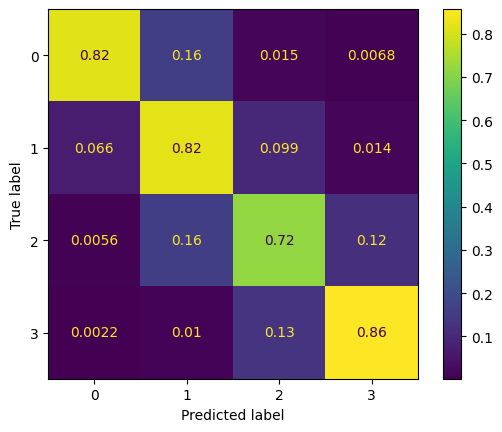

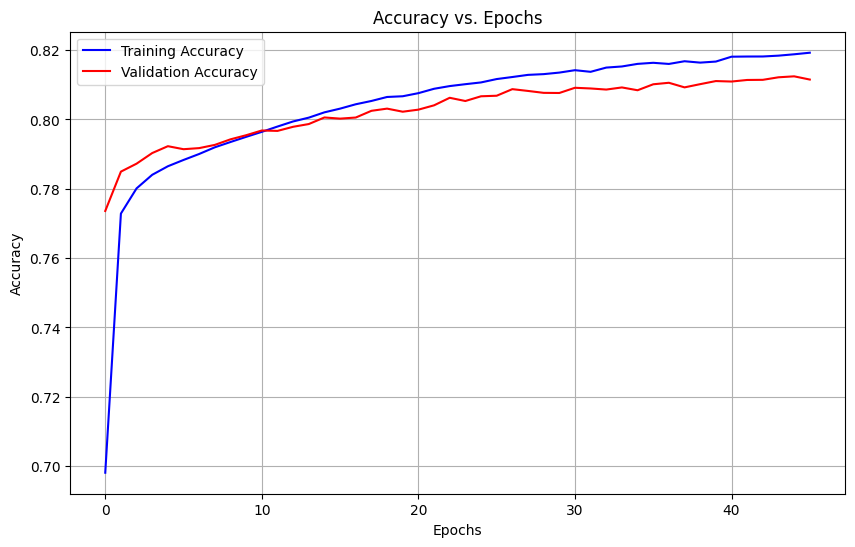

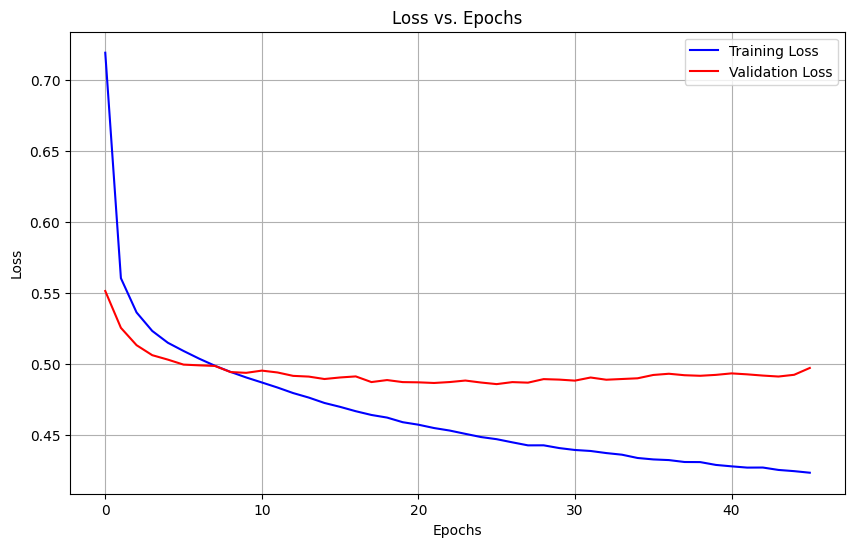

In [5]:
# Metric analysis

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f"\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

ConfusionMatrixDisplay.from_predictions(y_test_classes, y_pred_classes, normalize='true')
plt.show()

# accuracy vs epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# loss vs epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()